# Cálculo de area de agua superficial
Este código utiliza imágenes sentinel para encontrar el área lagunar en un área determinada a lo largo de un periodo de tiempo.


>Creador: **Borja Mir**
>Fecha: **20/04/2021**

In [1]:
import matplotlib.pyplot as plt
import ee 
import folium
# import geehydro
import os
import geemap
import ee.mapclient
import numpy as np
import datetime 
from IPython.display import Image
import pandas as pd
import calendar
from sklearn.linear_model import LinearRegression
import scipy.stats
import scipy
import seaborn as sns
#Esto sirve para que los plots se abran en una ventana aparte
#%matplotlib qt 

ee.Initialize()
mapa = geemap.Map(location=[-23.40, -68.23], zoom_start=9.5) # Aquí se determina donde se abre el mapa
mapa

Map(center=[-23.4, -68.23], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(childr…

In [2]:
area = ee.FeatureCollection("users/borjamirc/La_Brava") #Aquí linkealo a tu colección de earth engine en la ventana de assets, yo hago los shapes en qgis y los subo
#area = ee.FeatureCollection(mapa.draw_last_feature) # O aquí te toma la ultima figura dibujada en el mapa que se abrío en la entrada anterior

In [3]:


sentinel = ee.ImageCollection("COPERNICUS/S2_SR")


sentinel = (sentinel
                        .filterBounds(area)
                        .filterDate('2019-01-01', '2021-3-31')
                        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE',30))# Filtro por porcentaje de nubosidad           
           )



In [4]:
def NDWIsentinel (image):
    return image.normalizedDifference(['B3', 'B8']).gt(0) 
# .gt(0) devuelve una imagen booleana con 0 donde el valor es menor igual que 0 y 1 si es mayor (greater than 0)


def mNDWIsentinel(image):  
    return image.normalizedDifference(['B3', 'B11']).gt(0)  #sentinel red=3 nir=4 swir2=7  l8 red=4 nir=5 swir2=7  sen2 red=4 nir=8 swir2=12  


def TCWsentinel(image):
    tcw = image.expression(
    '0.1509 * BLUE + 0.1973 * GREEN + 0.3279 * RED + 0.3406 * NIR -0.7112 * SWIR1 - 0.4572 * SWIR2', {
      'NIR': image.select('B5'),
      'RED': image.select('B4'),
      'GREEN': image.select('B3'),
      'BLUE': image.select('B2'),
      'SWIR1': image.select('B11'),
      'SWIR2': image.select('B12')
    })
    return tcw.gt(0)


def EVIsentinel(image):
    evi = image.expression(
    '2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))', {
      'NIR': image.select('B5'),
      'RED': image.select('B4'),
      'BLUE': image.select('B2')
    })
    return evi

def NDVIsentinel(image):
    return image.normalizedDifference(['B8', 'B4'])

mNDWI=sentinel.map(mNDWIsentinel)
TCW=sentinel.map(TCWsentinel)
EVI=sentinel.map(EVIsentinel)
NDWI=sentinel.map(NDWIsentinel)
NDVI=sentinel.map(NDVIsentinel)
#map se usa para mapear una función sobre una colección de imágenes, ya que las funciones usan .addBands() se le agregan a la colección como banda nueva por imágen.

In [5]:
#Utilizo mediana envés de promedio para visualizar, así evito los valores anómalos (esto calcula el valor por pixel para toda la serie)
NDWImed = NDWI.median()
mNDWImed = mNDWI.median()
TCWmed = TCW.median()
EVImed = EVI.median()
NDVImed = NDVI.median()

imagen = sentinel.median()  
image_viz_params = {
    'bands': ['B4', 'B3', 'B2'], #agua:b11 b6 b3 o b7 b5 b2,  vegetacion: B7 B3 B2, normal: b4 b3 b2 
    'min': 0,
    'max': 6000, #Con este ajusta el brillo
    'gamma': [1, 1, 1]
}


mapa.addLayer(NDWImed,name='NDWI')
mapa.addLayer(mNDWImed,name='mNDWI')
mapa.addLayer(TCWmed,name='TCW')
mapa.addLayer(NDVImed,name='NDVI')
mapa.addLayer(imagen, image_viz_params, 'Color composite')




mapa

Map(bottom=150175.0, center=[-24.98942273194716, -65.92662596266125], controls=(WidgetControl(options=['positi…

In [6]:
#El Reducer reduce un area a un valor, aquí yo uso sum() ya que estoy contando los pixeles con agua
#para NDVI se puede usa mean() o el mismo sum() si en la función arriba lo dejas con un .gt(0.3) por ejemplo como te dije en el mail
def area_sum(image):
    dict = image.reduceRegion(ee.Reducer.sum(), area)
    return image.set(dict)

def area_mean(image):
    dict = image.reduceRegion(ee.Reducer.mean(), area)
    return image.set(dict)

## Esta parte es media jodida por que no he podido elegir yo el nombre de la banda que se genera, entonces escribo por ejemplo
## NDWI.getInfo() y veo el nombre de la banda

##Genero la serie de tiempo con los valores

area_mNDWI = mNDWI.select(['nd']).map(area_sum).aggregate_array('nd').getInfo()
area_NDWI = NDWI.select(['nd']).map(area_sum).aggregate_array('nd').getInfo()
area_TCW = TCW.select(['constant']).map(area_sum).aggregate_array('constant').getInfo()
area_NDVI = NDVI.select(['nd']).map(area_mean).aggregate_array('nd').getInfo()

In [7]:
#Armo el dataframe de pandas para mejor manejo
data=pd.DataFrame()

data['Timestamp']=sentinel.aggregate_array('system:time_start').getInfo()
data['Fecha']=[datetime.datetime.fromtimestamp(x//1000) for x in data['Timestamp']]

data['NDWI']=np.asarray(area_NDWI)*10*10/1000000 #De pixeles a km^2
data['mNDWI']=np.asarray(area_mNDWI)*10*10/1000000
data['TCW']=np.asarray(area_TCW)*10*10/1000000

data['NDVI']=np.asarray(area_NDVI)

data=data.sort_values(by=['Fecha'])
data

,Timestamp,Fecha,NDWI,mNDWI,TCW,NDVI
0,1547045367000,2019-01-09 11:49:27,0.318077,9.874999,12.473413,0.008058
1,1547909368000,2019-01-19 11:49:28,0.312582,9.556743,12.432157,0.006500
2,1548341372000,2019-01-24 11:49:32,0.346887,9.090811,12.210171,-0.000537
3,1550069372000,2019-02-13 11:49:32,1.858663,12.832873,12.842573,-0.006790
4,1550501368000,2019-02-18 11:49:28,1.268062,11.565705,12.748420,-0.001193
...,...,...,...,...,...,...
122,1614869371463,2021-03-04 11:49:31,0.274400,10.092030,12.499156,0.009816
123,1615301372182,2021-03-09 11:49:32,0.265600,9.631886,12.433052,0.007371
124,1615733371753,2021-03-14 11:49:31,0.281600,9.592831,12.409959,0.004369
125,1616597371361,2021-03-24 11:49:31,0.288500,9.872969,12.454459,0.013714


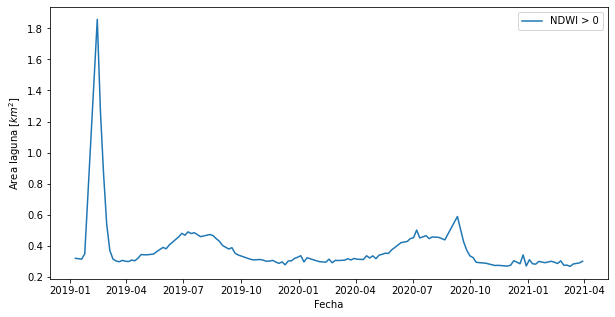

In [14]:


fig, axs=plt.subplots(figsize=(10,5))
axs.plot(data['Fecha'],data['NDWI'], label='NDWI > 0')
axs.set_xlabel('Fecha')
axs.set_ylabel('Area laguna [$km^2$]')
axs.legend()

# axs[1].plot(data['Fecha'],data['mNDWI'], label='mNDWI')
# axs[1].legend()

# axs[2].plot(data['Fecha'],data['TCW'],label='TCW')
# axs[2].legend()

# axs[3].plot(data['Fecha'],data['NDVI'],label='NDVI')
# axs[3].legend()

plt.show()

['Timestamp', 'Fecha', 'NDWI', 'mNDWI', 'TCW', 'NDVI']